In [1]:
import numpy as np
import xarray as xr
import pickle as pk
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression as lr 
from sklearn.metrics import r2_score as r2_score
from scipy.optimize import curve_fit as curve_fit
import statsmodels.api as sm
import matplotlib as mpl
mpl.rc('font',size=16,**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
def int_alpha(ands,ors):
    fit = lr().fit(ors,ands)
    return fit.intercept_, -fit.coef_
def pred(ands,ors):
    fit = lr().fit(ors,ands)
    ecs = fit.intercept_/-fit.coef_
    predict = fit.predict(ors)
    score = r2_score(ands,predict)
    return predict

def scoreme(ands,ors):
    fit = lr().fit(ors,ands)
    predict = fit.predict(ors)
    score = r2_score(ands,predict)
    return score

In [8]:
#read in step response data
path = '/Volumes/eSSD0/Papers/JoC_gFBK/Data/'
case = ['ctl.2']

    
pi = pk.load(open(path+'SI/b.e12.pi-control.T31_g37.ctl.2_ctl_diag.pk','rb'))
p1 = pk.load(open(path+'Outputs/b.e12.1pyCO2.T31_g37.ctl.closed.2_ctl_diag.pk','rb'))
ebp1  = pk.load(open(path+'Outputs/EB/b.e12.1pyCO2.T31_g37.ctl.closed.2_EB_gam.pk','rb'))
ebp1['net'] = ebp1['salb']+ebp1['Planck']+ebp1['lapse']+ebp1['q_tropo']+ebp1['cld_lw']+ebp1['cld_sw']+ebp1['ta_strato']
dp1 = ((p1['TSI']-1360.89)/1360.89)*100

In [9]:
p1intercepts = {}
p1alphas = {}
p1prediction = {}

for terms in ebp1.keys():

    p1intercepts[terms], p1alphas[terms] = int_alpha(ebp1[terms],dp1.reshape(-1,1))
    p1prediction[terms] = pred(ebp1[terms],dp1.reshape(-1,1))


In [10]:
tsi_addcons = sm.add_constant(dp1)
regres_ols = {}
fit = {}
conf = {}
error = {}
sig = {}
for keys in ebp1.keys():
    regres_ols[keys] = sm.OLS(ebp1[keys],tsi_addcons)
    fit[keys] = regres_ols[keys].fit()
    conf[keys] = fit[keys].conf_int()[1,:]
    error[keys] = fit[keys].params[1]-conf[keys][0]
    sig[keys] = fit[keys].pvalues[1] < 0.05

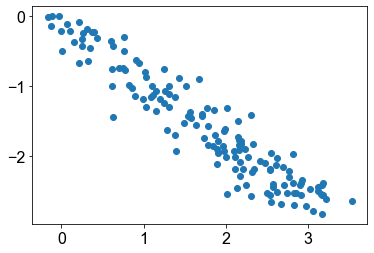

In [17]:
plt.scatter(ebp1['net'],dp1)

In [11]:
for keys in error.keys():
    print(keys)
    print(f'{round(conf[keys][0],3)} , {round(-p1alphas[keys][0],3)} , {round(conf[keys][1],3)}')

salb
-0.032 , -0.024 , -0.016
ta_strato
-0.393 , -0.383 , -0.373
lapse
-0.275 , -0.251 , -0.227
Planck
-0.169 , -0.119 , -0.069
q_strato
0.008 , 0.009 , 0.01
q_tropo
0.236 , 0.275 , 0.314
cld_lw
0.034 , 0.062 , 0.09
cld_sw
-0.737 , -0.686 , -0.635
IRF
1.13 , 1.167 , 1.204
cld_sw_lo
-0.263 , -0.235 , -0.207
cld_sw_hi
-0.492 , -0.451 , -0.41
cld_lw_lo
0.027 , 0.03 , 0.033
cld_lw_hi
0.003 , 0.032 , 0.061
net
-1.189 , -1.126 , -1.063


In [12]:
conffinal = {}
conffinal['$\lambda_{a}$'] = error['salb']
conffinal['$\lambda_{T-s}$'] = error['ta_strato']
conffinal['$\lambda_{P}$'] = error['Planck']
conffinal['$\lambda_{lr}$'] = error['lapse']
conffinal['$\lambda_{wv}$'] = error['q_tropo']
conffinal['$\lambda_{c-lw}$'] = error['cld_lw']
conffinal['$\lambda_{c-sw}$'] = error['cld_sw']
conffinal['$\lambda_{net}$'] = error['net']

In [13]:
conffinal

{'$\\lambda_{a}$': 0.008270008279933454,
 '$\\lambda_{T-s}$': 0.009848770247892658,
 '$\\lambda_{P}$': 0.05026218732047505,
 '$\\lambda_{lr}$': 0.024017101792302986,
 '$\\lambda_{wv}$': 0.03894289170370682,
 '$\\lambda_{c-lw}$': 0.02815236084787407,
 '$\\lambda_{c-sw}$': 0.0505958641684896,
 '$\\lambda_{net}$': 0.06298385754419322}

In [8]:
error_plot = np.stack(conffinal.values(),axis=0)

/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [9]:
p1final = {}
p1final['$\lambda_{a}$'] = p1alphas['salb'][0]
p1final['$\lambda_{T-s}$'] = p1alphas['ta_strato'][0]
p1final['$\lambda_{P}$'] = p1alphas['Planck'][0]
p1final['$\lambda_{lr}$'] = p1alphas['lapse'][0]
p1final['$\lambda_{wv}$'] = p1alphas['q_tropo'][0]
p1final['$\lambda_{c-lw}$'] = p1alphas['cld_lw'][0]
p1final['$\lambda_{c-sw}$'] = p1alphas['cld_sw'][0]
p1final['$\lambda_{g}$'] = p1alphas['net'][0]

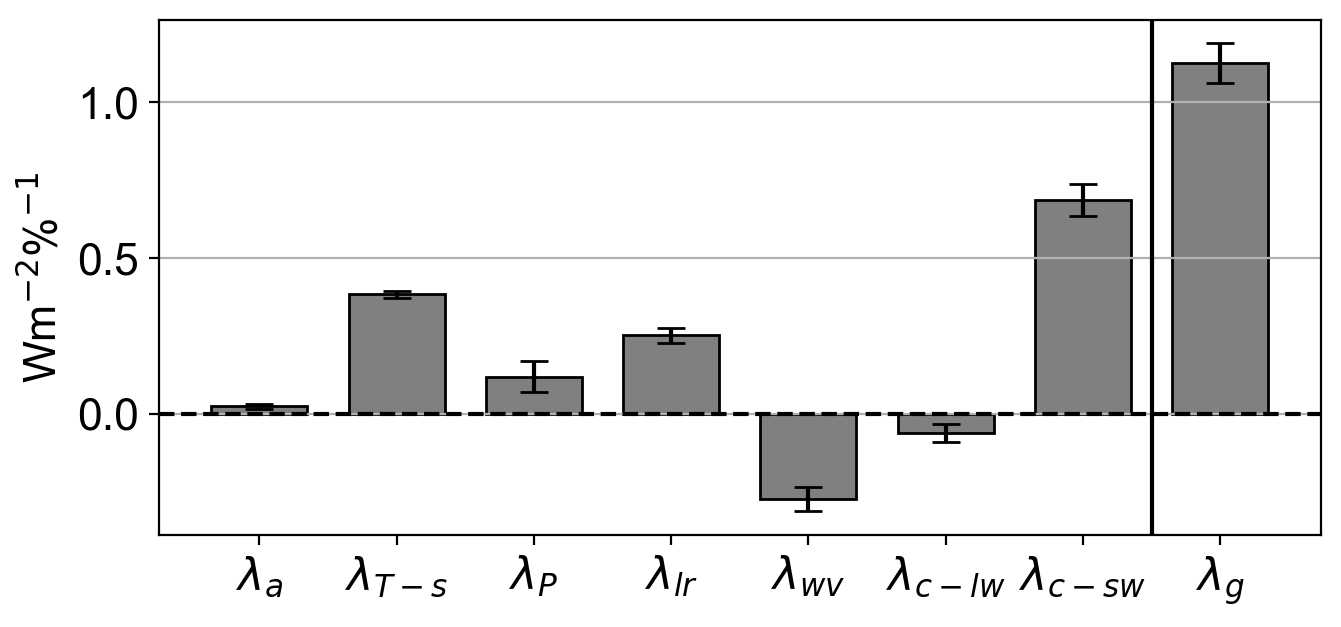

In [10]:
plt.figure(figsize=(7.5,7.5),dpi=200)

plt.subplot(211)
plt.bar(np.arange(8),list(p1final.values()), width=0.7,align='center',edgecolor='k', color='grey', yerr=error_plot, capsize=5)
plt.axhline(0,color='k',linestyle = '--')
plt.axvline(6.5,color='k')
plt.grid(axis='y')
plt.ylabel('Wm$^{-2}$%$^{-1}$')
plt.xticks(np.arange(8),labels = list(p1final.keys()));

plt.savefig('gfbk_bar.png',bbox_inches='tight')